<a href="https://colab.research.google.com/github/ElenaBetelgeuse/Convolutional-Network-Architectures/blob/main/%D0%90%D1%80%D1%85%D0%B8%D1%82%D0%B5%D0%BA%D1%82%D1%83%D1%80%D1%8B_%D1%81%D0%B2%D1%91%D1%80%D1%82%D0%BE%D1%87%D0%BD%D1%8B%D1%85_%D1%81%D0%B5%D1%82%D0%B5%D0%B9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Загрузка данных

In [ ]:
import torch
from torch import nn
import torchvision as tv
from torchsummary import summary
import time
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from IPython.display import clear_output
%matplotlib inline

import seaborn as sns
sns.set(font_scale=1.2)

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
!mkdir ./EMNIST
!mkdir ./EMNIST/raw

In [ ]:
!wget 'https://biometrics.nist.gov/cs_links/EMNIST/gzip.zip' -O ./EMNIST/raw/gzip.zip

--2024-04-10 09:17:46--  https://biometrics.nist.gov/cs_links/EMNIST/gzip.zip
Resolving biometrics.nist.gov (biometrics.nist.gov)... 18.235.227.114
Connecting to biometrics.nist.gov (biometrics.nist.gov)|18.235.227.114|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 561753746 (536M) [application/zip]
Saving to: ‘./EMNIST/raw/gzip.zip’

./EMNIST/raw/gzip.z 100%[===================>] 535.73M  47.6MB/s    in 12s     

2024-04-10 09:18:00 (44.7 MB/s) - ‘./EMNIST/raw/gzip.zip’ saved [561753746/561753746]



In [ ]:
data_path = "./"

In [ ]:
BATCH_SIZE = 256
transforms = tv.transforms.Compose([
    tv.transforms.Grayscale(3),
    tv.transforms.Resize((224, 224)),
    tv.transforms.ToTensor()
])

In [ ]:
train_dataset = tv.datasets.EMNIST(root=data_path, transform = transforms, split='mnist', train=True, download=True)
test_dataset = tv.datasets.EMNIST(root=data_path, transform = transforms, split='mnist', train=False, download=True)
train_iter = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE)
test_iter = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

Using downloaded and verified file: ./EMNIST/raw/gzip.zip
Extracting ./EMNIST/raw/gzip.zip to ./EMNIST/raw


In [ ]:
print("Количество классов в train: ", len(train_dataset.classes))
print("Количество классов в val: ", len(test_dataset.classes))
print("Количество классов одинаково: ", len(train_dataset.classes) == len(test_dataset.classes))

Количество классов в train:  10
Количество классов в val:  10
Количество классов одинаково:  True


In [ ]:
#train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)
#test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = True)

In [ ]:
train_dataset.targets.shape

torch.Size([60000])

In [ ]:
sns.set_style(style='white')

def show_images(dataset):
    fig, ax = plt.subplots(
        nrows=2, ncols=3, figsize=(8, 6),
        sharey=True, sharex=True
    )

    for fig_x in ax.flatten():
        idx = np.random.randint(low=0, high=6000)
        img, label = dataset[idx]
        fig_x.set_title(dataset.classes[label])
        fig_x.imshow(img.numpy().transpose((1, 2, 0)))

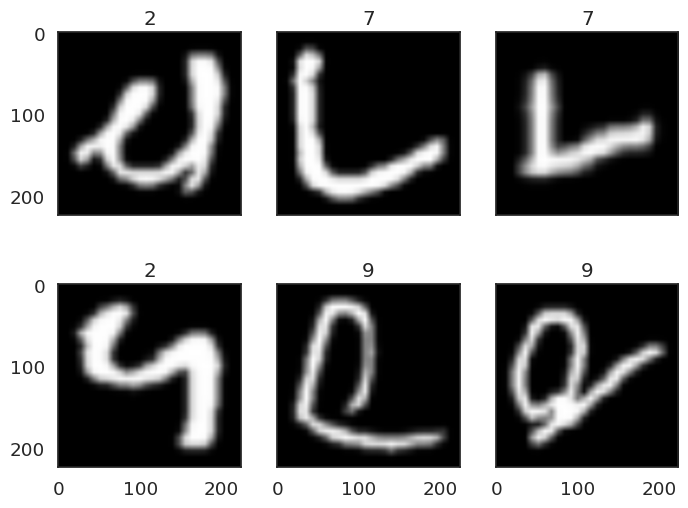

In [ ]:
show_images(train_dataset)

In [ ]:
def plot_learning_curves(history):
    '''
    Функция для вывода графиков лосса и метрики во время обучения.
    '''
    fig = plt.figure(figsize=(20, 7))

    plt.subplot(1,2,1)
    plt.title('Лосс', fontsize=15)
    plt.plot(history['loss']['train'], label='train')
    plt.plot(history['loss']['val'], label='val')
    plt.ylabel('лосс', fontsize=15)
    plt.xlabel('эпоха', fontsize=15)
    plt.legend()

    plt.subplot(1,2,2)
    plt.title('Точность', fontsize=15)
    plt.plot(history['acc']['train'], label='train')
    plt.plot(history['acc']['val'], label='val')
    plt.ylabel('лосс', fontsize=15)
    plt.xlabel('эпоха', fontsize=15)
    plt.legend()
    plt.show()

In [ ]:
def train(
    model,
    criterion,
    optimizer,
    train_batch_gen,
    val_batch_gen,
    num_epochs=5
):
    '''
    Функция для обучения модели и вывода лосса и метрики во время обучения.
    '''

    history = defaultdict(lambda: defaultdict(list))

    for epoch in range(num_epochs):
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0

        start_time = time.time()

        # устанавливаем поведение dropout / batch_norm  в обучение
        model.train(True)

        # на каждой "эпохе" делаем полный проход по данным
        for X_batch, y_batch in train_batch_gen:
            # обучаемся на текущем батче
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            logits = model(X_batch)

            loss = criterion(logits, y_batch.long().to(device))

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            train_loss += np.sum(loss.detach().cpu().numpy())
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            train_acc += np.mean(y_batch.cpu().numpy() == y_pred)

        # подсчитываем лоссы и сохраням в "историю"
        train_loss /= len(train_batch_gen)
        train_acc /= len(train_batch_gen)
        history['loss']['train'].append(train_loss)
        history['acc']['train'].append(train_acc)

        # устанавливаем поведение dropout / batch_norm в режим тестирования
        model.train(False)

        # полностью проходим по валидационному датасету
        for X_batch, y_batch in val_batch_gen:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            logits = model(X_batch)
            loss = criterion(logits, y_batch.long().to(device))
            val_loss += np.sum(loss.detach().cpu().numpy())
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            val_acc += np.mean(y_batch.cpu().numpy() == y_pred)

        # подсчитываем лоссы и сохраням в "историю"
        val_loss /= len(val_batch_gen)
        val_acc /= len(val_batch_gen)
        history['loss']['val'].append(val_loss)
        history['acc']['val'].append(val_acc)

        clear_output()

        # печатаем результаты после каждой эпохи
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(train_loss))
        print("  validation loss (in-iteration): \t{:.6f}".format(val_loss))
        print("  training accuracy: \t\t\t{:.2f} %".format(train_acc * 100))
        print("  validation accuracy: \t\t\t{:.2f} %".format(val_acc * 100))

        plot_learning_curves(history)

    return model, history

In [ ]:
# не забудем перемешать train
train_batch_gen = torch.utils.data.DataLoader(
    train_dataset, batch_size = BATCH_SIZE, shuffle=True
)
# валидационный датасет мешать не нужно, а точнее бессмысленно
# сеть на нём не обучается
val_batch_gen = torch.utils.data.DataLoader(
    test_dataset, batch_size = BATCH_SIZE, shuffle=False
)

Обучаем наши модели с нуля, поэтому везде убираем требования градиента и изменяем последний слой с количеством выходов 10 (по количеству классов)

In [ ]:
from torchvision.models import resnet18

Epoch 5 of 5 took 169.823s
  training loss (in-iteration): 	0.155504
  validation loss (in-iteration): 	0.146879
  training accuracy: 			95.59 %
  validation accuracy: 			95.89 %


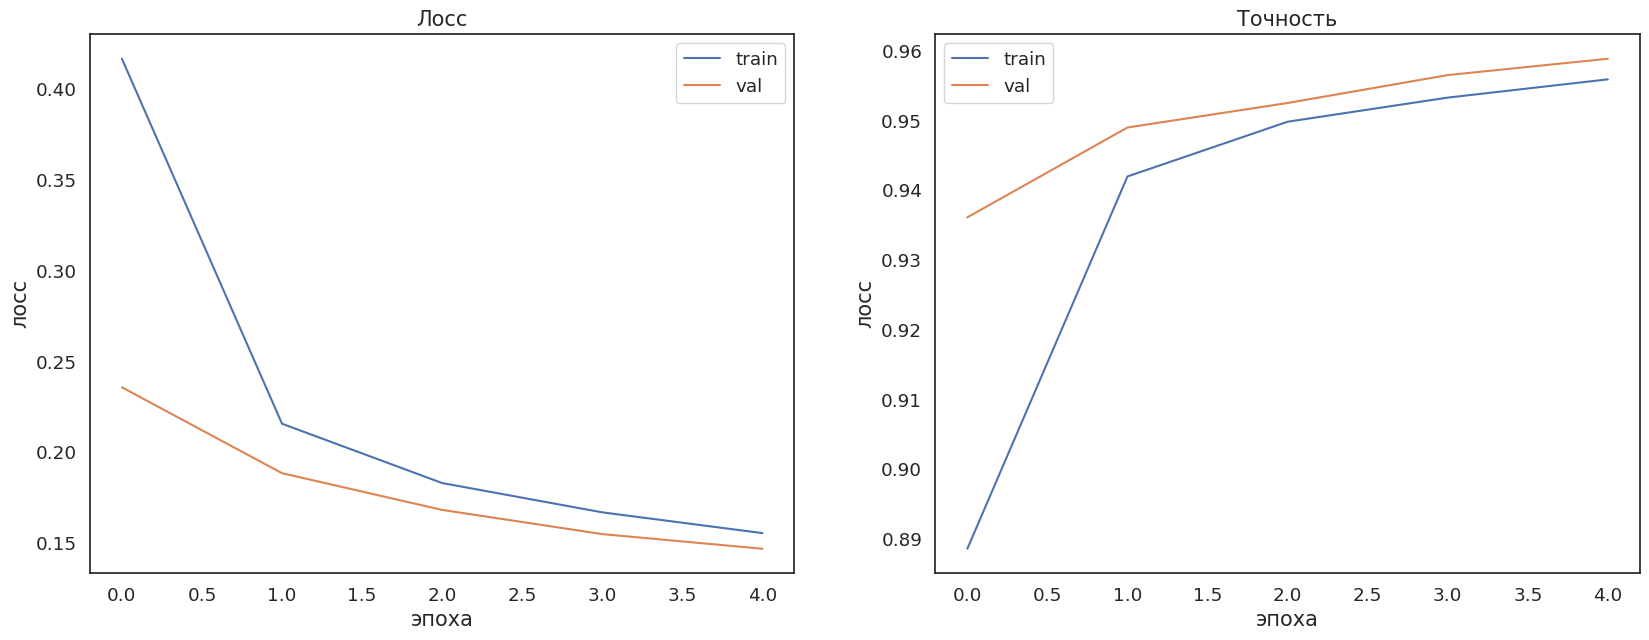

In [ ]:
model = nn.Sequential()

model.add_module('resnet18', resnet18(weights=True))
# Убираем требование градиента:
for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Linear(in_features=1000, out_features=10)

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

train_loss_resnet18 = clf_model, history = train(
    model, criterion, optimizer,
    train_batch_gen, val_batch_gen,
    num_epochs=5
)


In [ ]:
from torchvision.models import densenet161

In [ ]:
densenet_model = densenet161(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet161_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet161_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/hub/checkpoints/densenet161-8d451a50.pth
100%|██████████| 110M/110M [00:01<00:00, 69.1MB/s]


In [ ]:
print(densenet_model)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

Epoch 5 of 5 took 620.006s
  training loss (in-iteration): 	0.201538
  validation loss (in-iteration): 	0.194672
  training accuracy: 			94.28 %
  validation accuracy: 			94.62 %


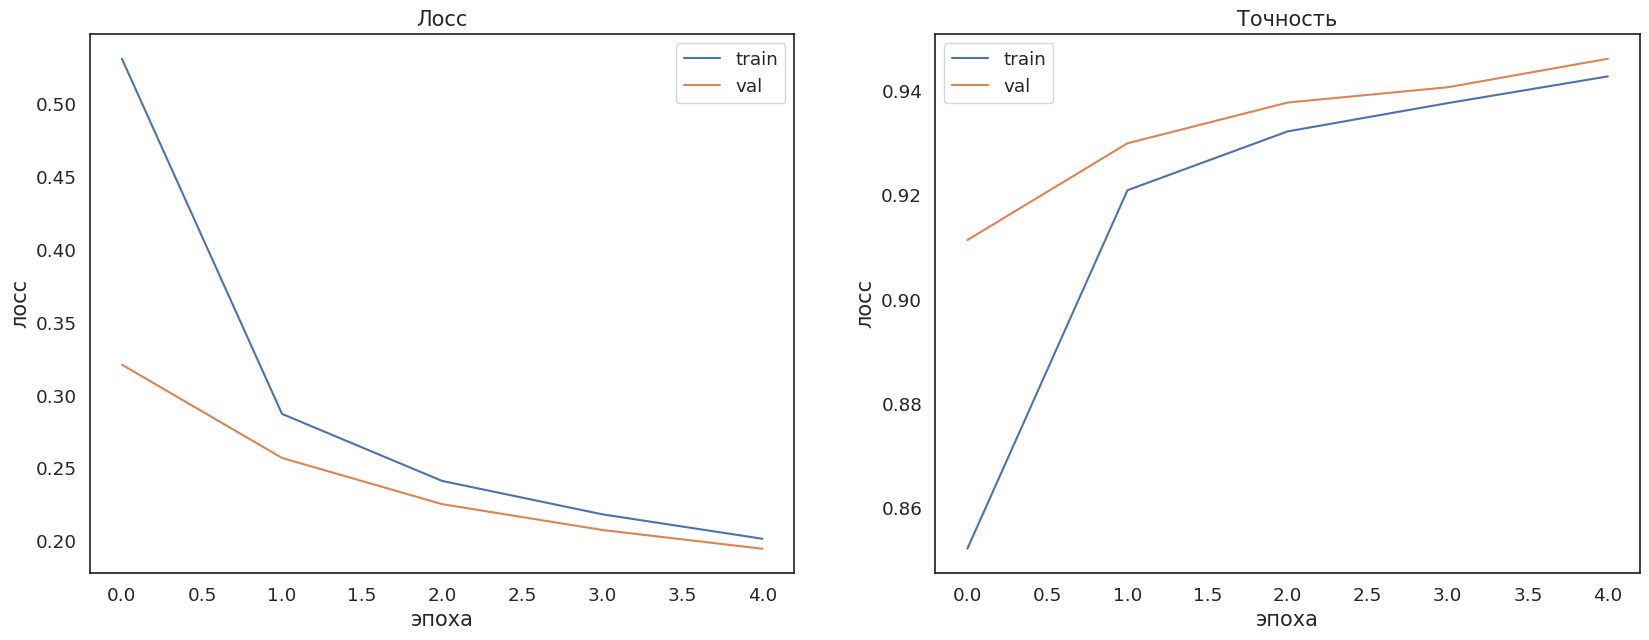

In [ ]:
model = nn.Sequential()

model.add_module('densenet161', densenet161(weights=True))
# Убираем требование градиента:
for param in model.parameters():
    param.requires_grad = False
model.fc = nn.Linear(in_features=1000, out_features=10)

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

train_loss_densenet161 = clf_model, history = train(
    model, criterion, optimizer,
    train_batch_gen, val_batch_gen,
    num_epochs=5
)


In [ ]:
from torchvision.models import vgg16

In [ ]:
vgg16_model = vgg16(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:06<00:00, 86.7MB/s]


In [ ]:
print(vgg16_model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Epoch 5 of 5 took 449.747s
  training loss (in-iteration): 	0.628772
  validation loss (in-iteration): 	0.421372
  training accuracy: 			79.40 %
  validation accuracy: 			86.62 %


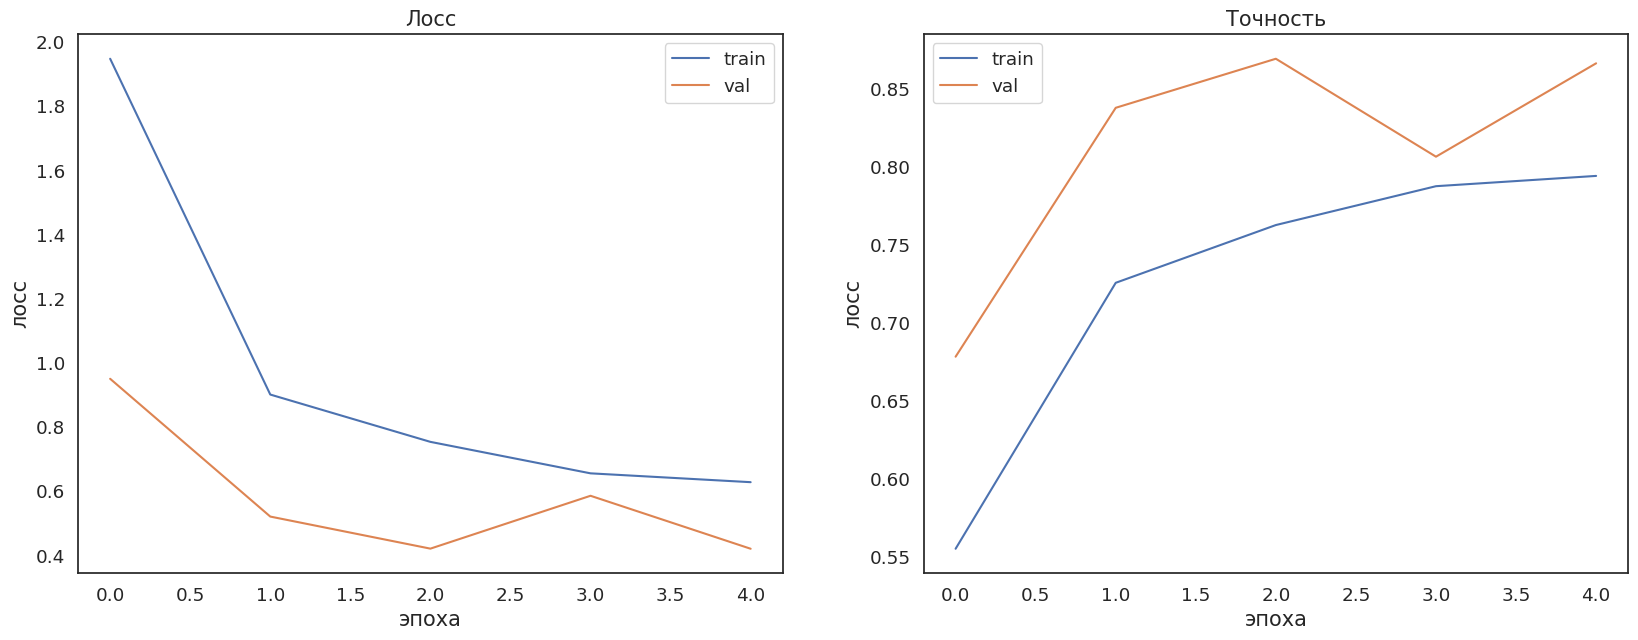

In [ ]:
model = nn.Sequential()

model.add_module('vgg16', vgg16(weights=True))
# Убираем требование градиента:
for param in model.parameters():
    param.requires_grad = False
model.fc = nn.Linear(in_features=1000, out_features=10)

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

train_loss_vgg16 = clf_model, history = train(
    model, criterion, optimizer,
    train_batch_gen, val_batch_gen,
    num_epochs=5
)


In [ ]:
from torchvision.models import inception_v3

In [ ]:
inception_v3_model = inception_v3(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 162MB/s] 


In [ ]:
inception_v3_model = inception_v3
inception_v3_model.aux_logits = False

In [ ]:
inception_v3_model(weights=True)

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [ ]:
BATCH_SIZE = 256
transforms = tv.transforms.Compose([
    tv.transforms.Grayscale(3),
    tv.transforms.Resize((299, 299)),
    tv.transforms.ToTensor(),
    tv.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
])

In [ ]:
train_dataset = tv.datasets.EMNIST(root=data_path, transform = transforms, split='mnist', train=True, download=True)
test_dataset = tv.datasets.EMNIST(root=data_path, transform = transforms, split='mnist', train=False, download=True)
train_iter = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE)
test_iter = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [ ]:
# не забудем перемешать train
train_batch_gen = torch.utils.data.DataLoader(
    train_dataset, batch_size = BATCH_SIZE, shuffle=True
)
# валидационный датасет мешать не нужно, а точнее бессмысленно
# сеть на нём не обучается
val_batch_gen = torch.utils.data.DataLoader(
    test_dataset, batch_size = BATCH_SIZE, shuffle=False
)

In [ ]:
classes = list(train_dataset.class_to_idx.keys())
dataiter = iter(train_batch_gen)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

torch.Size([256, 3, 299, 299])
torch.Size([256])


In [ ]:
inception = inception_v3(pretrained=True)
print(inception)

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [ ]:
# Freeze "features" network parameters
for param in inception.parameters():
    param.requires_grad = False

## Last layer has output containing 10 classes
inception.fc = nn.Linear(2048, 10)

In [ ]:
# migrate model to GPU
inception = inception.to(device)

In [ ]:
def evaluate_accuracy(data_iter, net):
    acc_sum, n = 0, 0
    net.eval()
    for X, y in data_iter:
        X, y = X.to(device), y.to(device)
        y_hat = net(X)
        acc_sum += (y_hat.argmax(axis=1) == y).sum()
        n += y.shape[0]
        return 0
    return acc_sum.item() / n

In [ ]:
def train(net, train_iter, test_iter, trainer, num_epochs):
    train_loss = []
    net.to(device)
    loss = nn.CrossEntropyLoss(reduction='sum')
    #net.train()
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, start = 0.0, 0.0, 0, time.time()
        net.train()
        for i, (X, y) in enumerate(train_iter):
            X, y = X.to(device), y.to(device)
            trainer.zero_grad()
            y_hat = net(X)
            l = loss(y_hat[0], y)
            l.backward()
            trainer.step()
            train_l_sum += l.item()
            train_acc_sum += (y_hat[0].argmax(axis=1) == y).sum().item()
            n += y.shape[0]

            if i % 100 == 0:
              print(f"Step {i}. time since epoch: {time.time() -  start:.3f}. "
                    f"Train acc: {train_acc_sum / n:.3f}. Train Loss: {train_l_sum / n:.3f}")
        test_acc = evaluate_accuracy(test_iter, net.to(device))
        print('-' * 20)
        train_loss.append(train_l_sum / n)
        print(f'epoch {epoch + 1}, loss {train_l_sum / n:.4f}, train acc {train_acc_sum / n:.3f}'
              f', test acc {test_acc:.3f}, time {time.time() - start:.1f} sec')
    return train_loss

In [ ]:
# Убираем требование градиента:
for param in inception.parameters():
    param.requires_grad = False
inception.fc = nn.Linear(in_features=2048, out_features=10)
params_to_update = []
for name, param in inception.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)
trainer = torch.optim.Adam(params_to_update, lr=0.001)
train_loss_inception_v3=train(inception, train_iter, test_iter, trainer, 5)

	 fc.weight
	 fc.bias
Step 0. time since epoch: 2.580. Train acc: 0.129. Train Loss: 2.322
Step 100. time since epoch: 188.000. Train acc: 0.674. Train Loss: 1.223
Step 200. time since epoch: 373.393. Train acc: 0.741. Train Loss: 0.954
--------------------
epoch 1, loss 0.9025, train acc 0.754, test acc 0.000, time 436.6 sec
Step 0. time since epoch: 2.032. Train acc: 0.852. Train Loss: 0.519
Step 100. time since epoch: 186.468. Train acc: 0.846. Train Loss: 0.533
Step 200. time since epoch: 374.396. Train acc: 0.848. Train Loss: 0.516
--------------------
epoch 2, loss 0.5114, train acc 0.848, test acc 0.000, time 437.5 sec
Step 0. time since epoch: 2.044. Train acc: 0.867. Train Loss: 0.447
Step 100. time since epoch: 187.374. Train acc: 0.861. Train Loss: 0.453
Step 200. time since epoch: 372.697. Train acc: 0.861. Train Loss: 0.450
--------------------
epoch 3, loss 0.4493, train acc 0.861, test acc 0.000, time 435.9 sec
Step 0. time since epoch: 2.045. Train acc: 0.867. Train Los

In [ ]:
train_loss_vgg16 = train_loss_vgg16[1]['loss']['val']
train_loss_resnet18 = train_loss_resnet18[1]['loss']['val']
train_loss_densenet161 = train_loss_densenet161[1]['loss']['val']

In [ ]:
with open('train_loss_resnet18.txt', 'w') as filehandle:
  for listitem in train_loss_resnet18: filehandle.write('%s\n' % listitem)
with open('train_loss_densenet161.txt', 'w') as filehandle:
  for listitem in train_loss_densenet161: filehandle.write('%s\n' % listitem)
with open('train_loss_vgg16.txt', 'w') as filehandle:
  for listitem in train_loss_vgg16: filehandle.write('%s\n' % listitem)
with open('train_loss_inception_v3.txt', 'w') as filehandle:
  for listitem in train_loss_inception_v3: filehandle.write('%s\n' % listitem)

In [ ]:
def get_list(name):
  list = [] # open file and read the content in a list
  nameFile='/content/train_loss_'+name+'.txt'
  with open(nameFile, 'r') as filehandle:
    for line in filehandle:
      currentPlace = line[:-1]
      list.append(currentPlace)
  return list

In [ ]:
import pandas as pd
df=pd.DataFrame()
for file in ['densenet161','resnet18','vgg16','inception_v3']:
  df[file]=get_list(file)
df

,densenet161,resnet18,vgg16,inception_v3
0,0.3211349558085203,0.2358202774077654,0.9509114012122154,0.9025402542750041
1,0.2570478798821568,0.18850364089012145,0.5216356560587883,0.5114050521214804
2,0.22530164550989867,0.1682704111561179,0.42172585278749464,0.4493082712173462
3,0.2075590243563056,0.15494696609675884,0.5864164665341377,0.419784802309672
4,0.19467154946178197,0.14687918946146966,0.42137188017368316,0.40166662610371906


<ipython-input-73-dfb3d8d2a5d7>:2: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-b" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot( df['densenet161'], 'o-b', label='densenet161', linestyle='--')
<ipython-input-73-dfb3d8d2a5d7>:3: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-r" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(df['resnet18'], 'o-r', label='resnet18', linestyle='--')
<ipython-input-73-dfb3d8d2a5d7>:4: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-.g" (-> linestyle='-.'). The keyword argument will take precedence.
  plt.plot(df['vgg16'],'o-.g', label='vgg16', linestyle='--')
<ipython-input-73-dfb3d8d2a5d7>:5: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-.y" (-> linestyle='-.'). The keyword ar

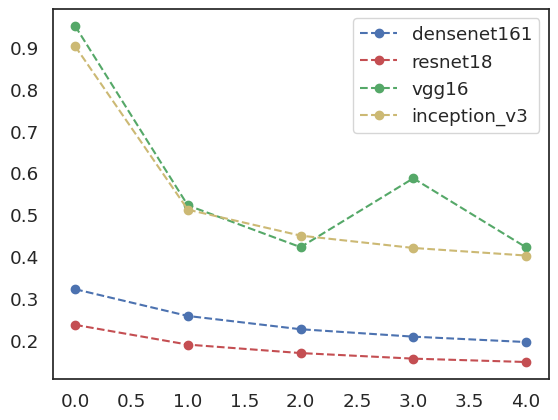

In [ ]:
df=df.astype(float)
plt.plot( df['densenet161'], 'o-b', label='densenet161', linestyle='--')
plt.plot(df['resnet18'], 'o-r', label='resnet18', linestyle='--')
plt.plot(df['vgg16'],'o-.g', label='vgg16', linestyle='--')
plt.plot(df['inception_v3'],'o-.y', label='inception_v3', linestyle='--')
plt.legend()